In [1]:
pip install seaborn polars pandas numpy scikit-learn ydata_profiling pip xgboost -U -q #u = update , q = reduce output displayed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 53.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 97.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.7 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Note: you may need to resta

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest , f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import seaborn as sns
import tqdm
import os


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csai-253-project-phase-2/sample_submission.csv
/kaggle/input/csai-253-project-phase-2/train.csv
/kaggle/input/csai-253-project-phase-2/test.csv


In [3]:
df = pl.read_csv("/kaggle/input/csai-253-project-phase-2/train.csv")
df_test = pl.read_csv("/kaggle/input/csai-253-project-phase-2/test.csv")

In [3]:
df.shape

(938583, 22)

In [27]:
df = df.unique()
df.shape

(842396, 22)

In [4]:
"""
Id: Unique identifier for each row in the test set.
flow_time: Duration of network flow.
header_size: Size of the packet headers.
packet_duration: Duration of individual packets.
overall_rate: Overall data transfer rate.
src_rate: Data transfer rate from the source.
dst_rate: Data transfer rate towards the destination.
fin_packets: Number of packets flagged as finished (FIN).
urg_packets: Number of urgent packets (URG).
rst_packets: Number of reset packets (RST).
max_value: Maximum value observed in packet data.
syn_flags: Number of SYN (synchronize) flags detected.
rst_flags: Number of RST (reset) flags detected.
psh_flags: Number of PSH (push) flags detected.
ack_flags: Number of ACK (acknowledge) flags detected.
protocol_http: Indicates HTTP protocol usage.
protocol_https: Indicates HTTPS protocol usage.
protocol_tcp: Indicates TCP protocol usage.
protocol_udp: Indicates UDP protocol usage.
protocol_icmp: Indicates ICMP protocol usage.
label (only in train.csv): Type of cyber-attack to be predicted (e.g., DDoS, DoS, benign).
"""
df.schema

Schema([('flow_time', Float64),
        ('header_size', Float64),
        ('packet_duration', Float64),
        ('overall_rate', Float64),
        ('src_rate', Float64),
        ('dst_rate', Float64),
        ('fin_packets', Float64),
        ('urg_packets', Float64),
        ('rst_packets', Float64),
        ('max_value', Float64),
        ('value_covariance', Float64),
        ('fin_flags', Int64),
        ('syn_flags', Int64),
        ('rst_flags', Int64),
        ('psh_flags', Int64),
        ('ack_flags', Int64),
        ('protocol_http', Int64),
        ('protocol_https', Int64),
        ('protocol_tcp', Int64),
        ('protocol_udp', Int64),
        ('protocol_icmp', Int64),
        ('label', String)])

In [5]:
df.describe()

statistic,flow_time,header_size,packet_duration,overall_rate,src_rate,dst_rate,fin_packets,urg_packets,rst_packets,max_value,value_covariance,fin_flags,syn_flags,rst_flags,psh_flags,ack_flags,protocol_http,protocol_https,protocol_tcp,protocol_udp,protocol_icmp,label
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,"""938583"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",13.42515,101813.423375,82.664589,9163.49561,9163.49561,0.000002,0.099474,5.850813,37.137514,177.16136,29689.164549,0.087102,0.208346,0.091149,0.088415,0.121502,0.048001,0.054196,0.574175,0.21141,0.164314,null
"""std""",5898.098733,1.8014e6,166.986325,100180.600226,100180.600226,0.000898,0.299712,70.715367,324.61358,515.425327,356901.659348,0.281984,0.406126,0.287821,0.283898,0.32671,0.213769,0.226403,0.494468,0.408309,0.37056,null
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""BenignTraffic"""
"""25%""",0.0,54.0,64.0,2.077074,2.077074,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
"""50%""",0.0,54.0,64.0,15.703769,15.703769,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,null
"""75%""",0.101755,364.0,64.0,117.774989,117.774989,0.0,0.0,0.0,0.01,55.14,1.184216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,null
"""max""",4.9301e6,3.3111737e8,6525.74,7.340032e6,7.340032e6,0.848465,19.5,4136.7,9331.5,30329.2,1.3728e8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"""Recon"""


In [4]:
#how may classes do we have?
print(df["label"].unique().value_counts().sum()["count"][0] ," unique labels")
# df = df.with_columns(pl.col("label").str.to_lowercase()) # case folding , expression object: pl.col("label")
#Are the classes un-balanced
quickOVERVIEW = df["label"].value_counts().with_columns((pl.col("count")/df["label"].shape[0] *100).alias("percentage"))
quickOVERVIEW

6  unique labels


label,count,percentage
str,u32,f64
"""DDoS""",687027,73.198321
"""BenignTraffic""",21987,2.342574
"""Recon""",6433,0.685395
"""MITM""",6313,0.67261
"""DoS""",163428,17.412205
"""Mirai""",53395,5.688895


<BarContainer object of 6 artists>

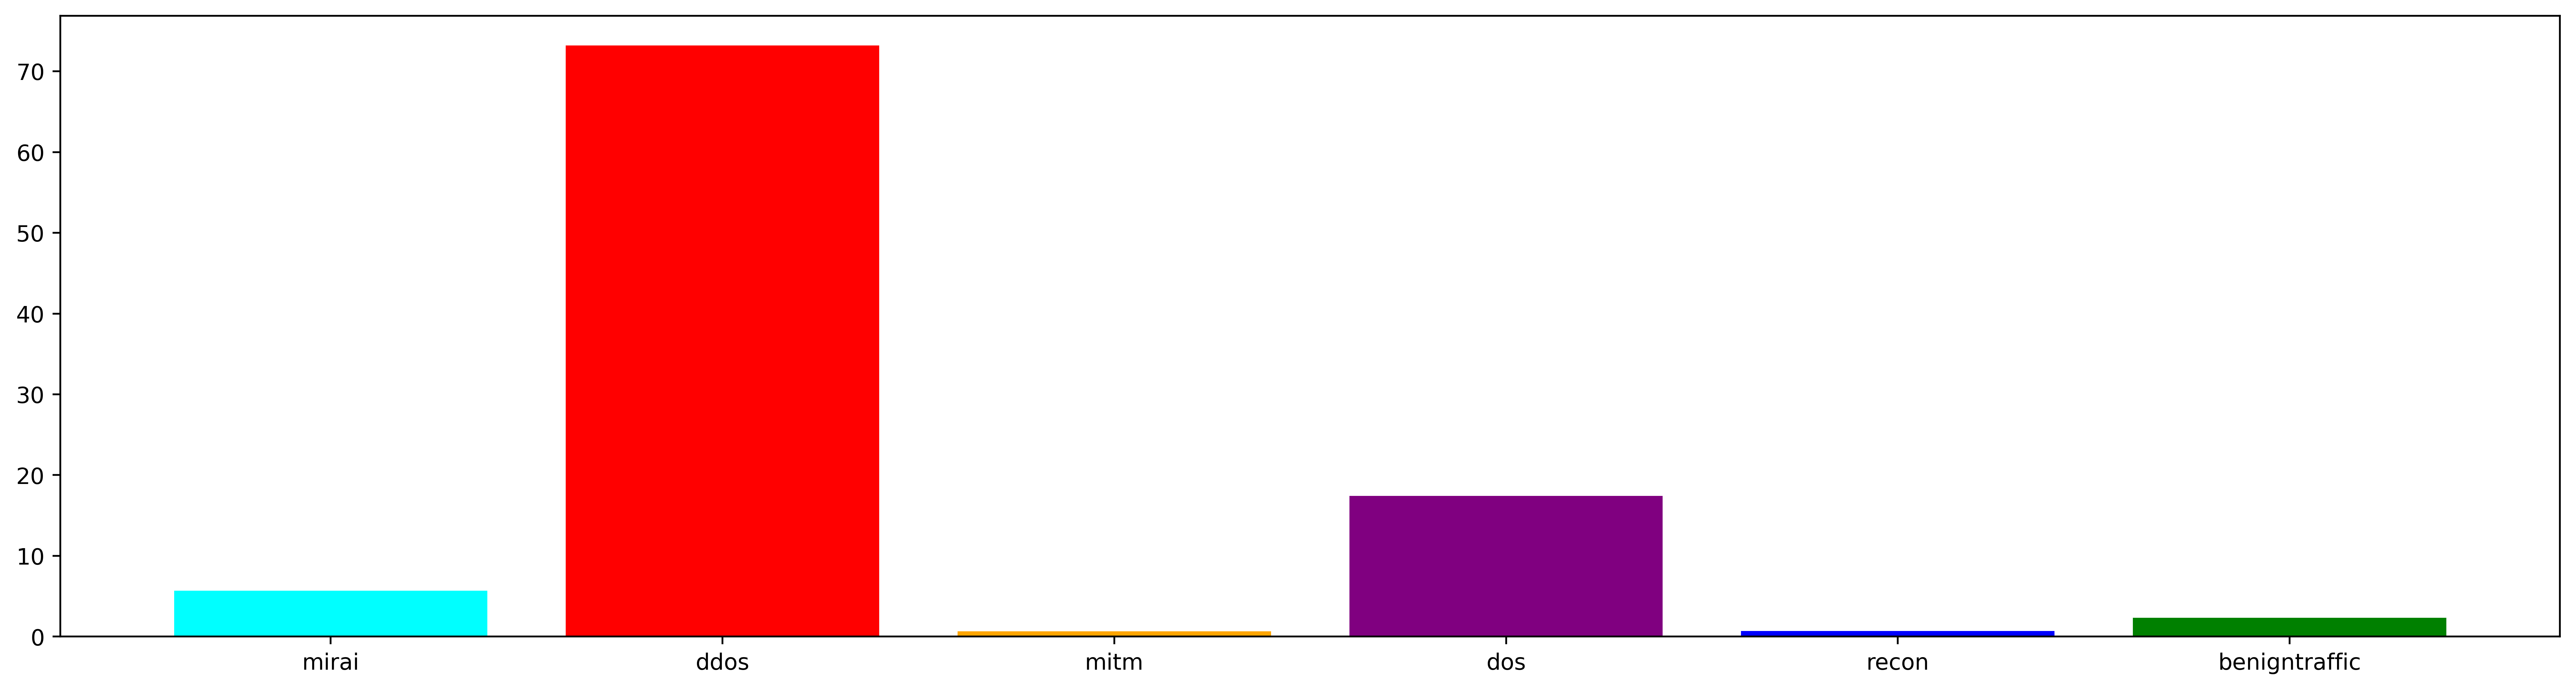

In [7]:
plt.figure(figsize=(20, 5), dpi=500)
plt.bar(
    quickOVERVIEW["label"], 
    height=quickOVERVIEW["percentage"] , 
    color= quickOVERVIEW["label"].replace({
    "ddos": "red",             
    "recon": "blue",           
    "benigntraffic": "green", 
    "mitm": "orange",          
    "dos": "purple",          
    "mirai": "cyan"           
}
))

In [8]:
profile = ProfileReport(df.to_pandas(), title="Profiling Report" , explorative=True , lazy= True , minimal = True)
# Display the report (Kaggle should automatically render it)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:03<00:00,  7.08it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
def skimmer(df: pl.DataFrame) -> dict:
    out = {}
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            out[f"{col}"] = {"col_unique_values": df[col].unique().to_list(), "data_type": df[col].dtype}
        else:
            out[f"{col}"] = {"col_values_range": [df[col].min(), df[col].max()], "data_type": df[col].dtype}
    return out

skimmer(df)

{'flow_time': {'col_values_range': [0.0, 4930147.302], 'data_type': Float64},
 'header_size': {'col_values_range': [0.0, 331117370.0], 'data_type': Float64},
 'packet_duration': {'col_values_range': [0.0, 6525.74], 'data_type': Float64},
 'overall_rate': {'col_values_range': [0.0, 7340032.0], 'data_type': Float64},
 'src_rate': {'col_values_range': [0.0, 7340032.0], 'data_type': Float64},
 'dst_rate': {'col_values_range': [0.0, 0.848465429], 'data_type': Float64},
 'fin_packets': {'col_values_range': [0.0, 19.5], 'data_type': Float64},
 'urg_packets': {'col_values_range': [0.0, 4136.7], 'data_type': Float64},
 'rst_packets': {'col_values_range': [0.0, 9331.5], 'data_type': Float64},
 'max_value': {'col_values_range': [42.0, 30329.2], 'data_type': Float64},
 'value_covariance': {'col_values_range': [0.0, 137284386.3],
  'data_type': Float64},
 'fin_flags': {'col_values_range': [0, 1], 'data_type': Int64},
 'syn_flags': {'col_values_range': [0, 1], 'data_type': Int64},
 'rst_flags': {'co

In [10]:
for col in tqdm.tqdm(df.select(cs.numeric()).columns):
    df = df.with_columns(pl.col(col).abs())
    

100%|██████████| 21/21 [00:00<00:00, 125.86it/s]


# Feature Engineering & Selection


In [11]:
ScaledFeatures =  StandardScaler().fit_transform(df.select(cs.numeric()))
df_new_scaled = pl.concat(items = [pl.DataFrame(ScaledFeatures , schema = df.select(cs.numeric()).columns) , df.select("label")] ,  how="horizontal")


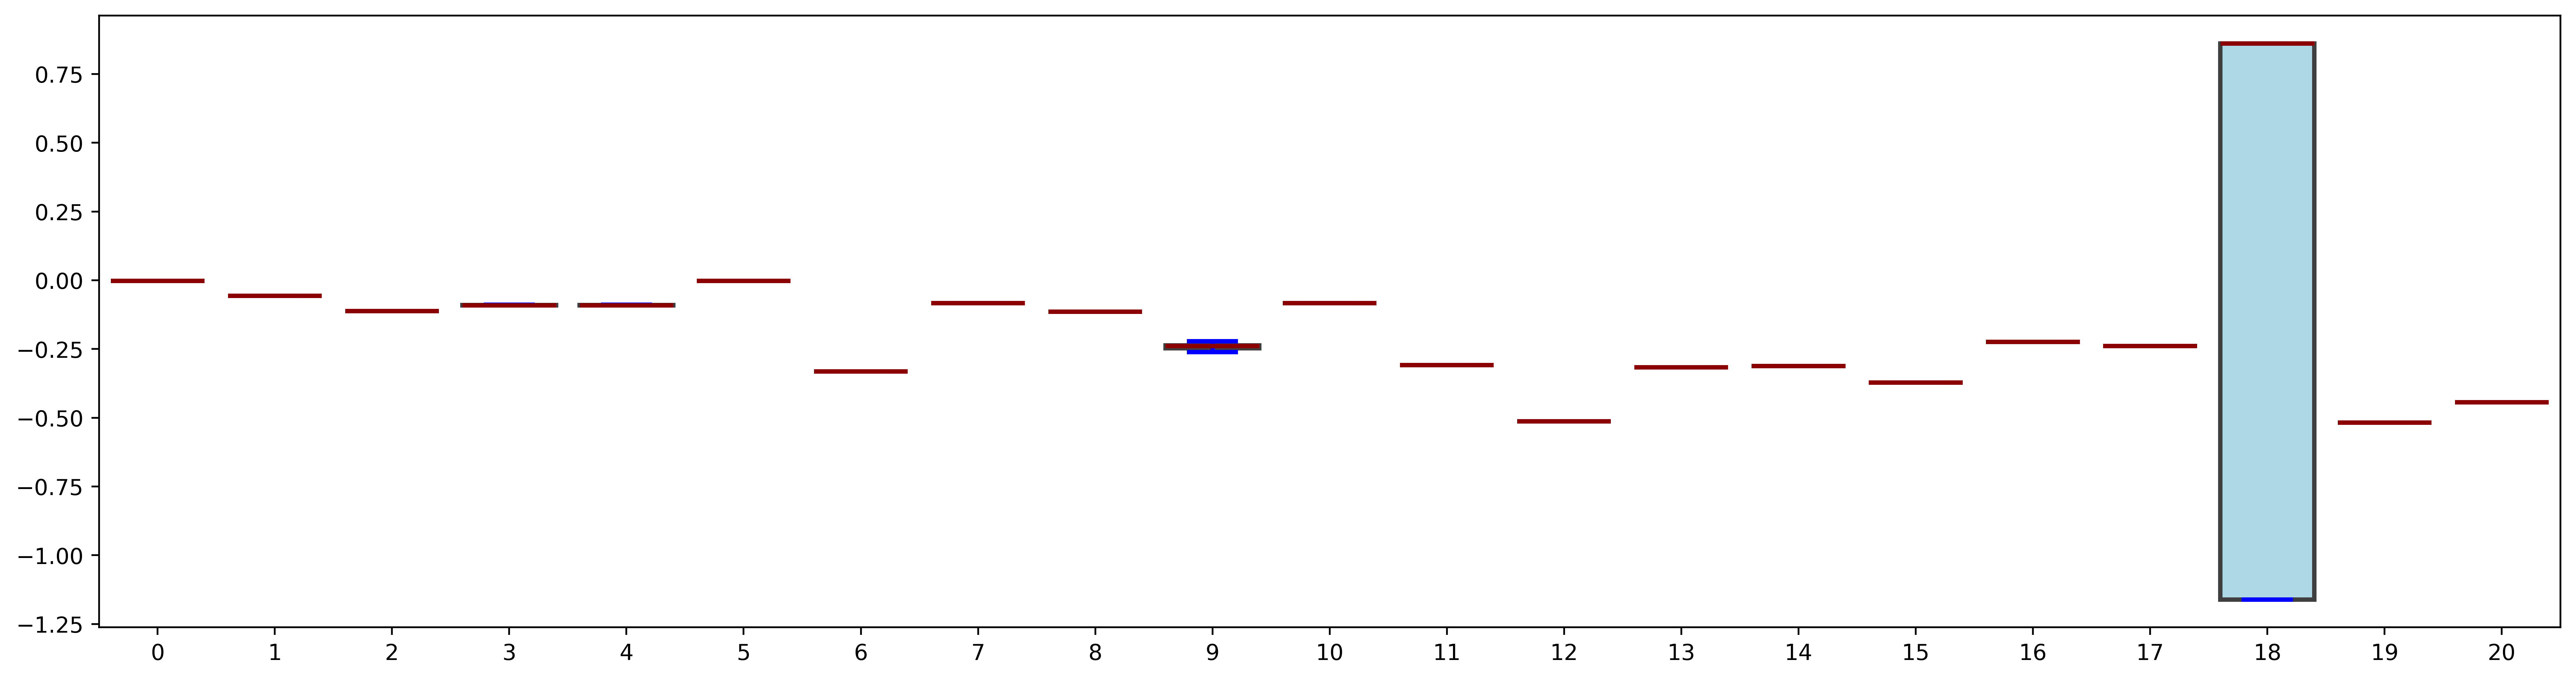

In [12]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=ScaledFeatures,#numeric columns only
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    # gap=1.5
)

plt.show()

In [13]:
df[df.columns[18]].min() , df[df.columns[18]].max() , df.columns[18]

(0, 1, 'protocol_tcp')

In [14]:
df[[col for i, col in enumerate(df.columns) if i == 0 or i==3 or i==4 or i==9]].describe()

statistic,flow_time,overall_rate,src_rate,max_value
str,f64,f64,f64,f64
"""count""",938583.0,938583.0,938583.0,938583.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",13.42515,9163.49561,9163.49561,177.16136
"""std""",5898.098733,100180.600226,100180.600226,515.425327
"""min""",0.0,0.0,0.0,42.0
"""25%""",0.0,2.077074,2.077074,50.0
"""50%""",0.0,15.703769,15.703769,54.0
"""75%""",0.101755,117.774989,117.774989,55.14
"""max""",4.9301e6,7.340032e6,7.340032e6,30329.2


In [15]:
#feature selection 
selector = SelectKBest(score_func=f_classif, k=10)

selector.fit(df.select(cs.numeric()), df["label"])

selected_indices = selector.get_support(indices=True)
print(selected_indices , len(selected_indices),"features")
selected_features = [df.select(cs.numeric()).columns[i] for i in selected_indices]
print("\nSelected features: \n", selected_features)

[ 7  8  9 10 11 15 17 18 19 20] 10 features

Selected features: 
 ['urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'ack_flags', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']


In [ ]:
tsne = TSNE(n_components=2, random_state=0 , )  # data reduction , #method{‘barnes_hut’, ‘exact’}, default=’barnes_hut’
tsne_data = tsne.fit_transform(df_new_scaled.drop('label' , strict = False))

In [ ]:
# not as we did in phase 1 , we will be testing undersampling and oversampling, 
# validated my idea by generative pre-trained transformers

"""You're dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.

Here's a breakdown of your idea, and some suggestions:

---

### ✅ Your Plan (Under + Over Sampling):
Using **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here's how it might work:

#### Step-by-step version of your plan:
1. **Undersample "ddos"** to reduce its impact.
2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.
3. **Possibly leave "dos" as is**, or slightly adjust it.

---

### 🧠 Tips on Executing It:

#### 1. ⚖️ **Target Balance Strategy**
Decide your final desired sample size per class. Example ideas:
- Match to the size of "mirai" (~50K)
- Or go a bit lower to reduce training size, say ~30K per class
- Avoid exact balance — slight randomness can help generalization

#### 2. 🧹 **Undersampling "ddos"**
You can randomly select ~30K–50K rows from "ddos" (from 687K). Make sure to **shuffle** before picking.

#### 3. 🔁 **Oversampling Minorities**
Use techniques like:
- **Random Oversampling** (e.g., simple duplication)
- **SMOTE/ADASYN** (synthetic data generation, if the features support it — i.e., numeric and continuous)

> Note: SMOTE doesn’t work well with categorical data unless encoded carefully.

#### 4. 🧪 **Be Careful with Oversampling**
If you're evaluating on the same dataset, make sure not to **leak duplicated synthetic samples into your validation set** — only oversample in the training split.

---

### ⚖️ Alternative: Use Class Weights
If you're using tree-based models (like XGBoost, LightGBM) or neural nets, consider using **class weighting** instead. It avoids changing the actual data and simply adjusts the cost of misclassification.

---

### 👀 Example Target Distribution
| Label          | Target Count |
|----------------|--------------|
| ddos           | 30,000       |
| benigntraffic  | 30,000       |
| mitm           | 30,000       |
| mirai          | 30,000       |
| recon          | 30,000       |
| dos            | 30,000       |

You could tune this depending on whether you want full balance or slight realism.

---

### 📦 TL;DR
- Your under+over strategy is solid.
- Make sure not to leak synthetic samples into validation/test.
- Consider class weights as a simpler alternative if supported.
- Don’t overdo oversampling — can lead to overfitting if minority class is too tiny.

Would you like help with writing some code to implement this in Python (e.g., using `pandas`, `sklearn`, `imbalanced-learn`)?"""

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours
# Define the undersampling strategy: only touch 'ddos'
undersample_strategy = {'DDoS': 500000}

# Note: RandomUnderSampler defaults to sampling *with replacement* if the
# target count is higher than the original count for a specified class,
# but here we are strictly reducing.
# rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
enn = EditedNearestNeighbours(sampling_strategy=['DDoS'], n_neighbors=3, kind_sel='mode', n_jobs=-1)
X_res, y_res = enn.fit_resample(df.select(['flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp'])
                                ,df['label'])


In [ ]:
#Just a tester


X_train, X_test, y_train, y_test = train_test_split(df.select(selected_features), df["label"], test_size=0.25, random_state=42)


rf_model = RandomForestClassifier(random_state=42, class_weight="balanced" , n_jobs=-1)  # class_weight="balanced" helps with imbalance
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_numeric = le.fit_transform(df['label'])  # now 0,1,2
map_ = {}
map_.update({i: val for i, val in enumerate(pd.Series(le.classes_).to_list())})
map_

{0: 'BenignTraffic', 1: 'DDoS', 2: 'DoS', 3: 'MITM', 4: 'Mirai', 5: 'Recon'}

In [5]:
X_train, X_test, y_train, y_test = train_test_split((df.select('flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp').to_numpy()), y_numeric,
                                                    test_size=0.25, random_state=42)

In [6]:
import xgboost as xgb
import time

start_time = time.time()

#gamma=0, learning_rate=0.03, min_child_weight=7, reg_lambda=0.4, subsample=0.6

initial_model = xgb.XGBClassifier(n_estimators=1000,
                    gamma = 0 ,
                    max_depth=None, 
                    learning_rate=0.01,
                    num_parallel_tree=10
                    subsample=0.7,
                    colsample_bytree=0.8, 
                    colsample_bylevel=0.8, 
                    base_score=0.5,
                    tree_method= 'hist',device = 'cuda',
                    min_child_weight = 7, reg_lambda =0.1,
                    random_state=42, seed=42
                                 )

init_mod = initial_model.fit(df.select('flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp').to_numpy(), y_numeric, 
                    # early_stopping_rounds=10, 
                    # eval_set=[(X_test, y_test)], 
                             # eval_metric='error', 
                    verbose=100)

print("--- %s seconds ---" % (time.time() - start_time))

--- 336.35182213783264 seconds ---


In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

bagging_model = BaggingClassifier(
    estimator=RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    n_estimators=10,
    bootstrap=True,
    oob_score=True,  # Use out-of-bag samples for validation
    n_jobs=-1,
    random_state=42,
)

bagging_model.fit(df.select('flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp').to_numpy(), y_numeric )


NameError: name 'X_test' is not defined

In [9]:
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Target': init_mod.predict((df_test.select('flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp').to_numpy()))
})
submission['Target'] = submission['Target'].replace(map_)
# submission.to_csv("/kaggle/working/submission.csv" ,index=False)

In [10]:
submission

,Id,Target
0,0,DDoS
1,1,DoS
2,2,DDoS
3,3,DDoS
4,4,DoS
...,...,...
104282,104282,DDoS
104283,104283,DDoS
104284,104284,DDoS
104285,104285,DDoS


In [13]:
submission
submission.to_csv("/kaggle/working/submission.csv" ,index=False)

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score , classification_report

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=256,
    learning_rate_init=0.001,
    max_iter=10000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=True
)
mlp.fit(
    df.select('flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp').to_numpy()
    , y_numeric
) #X_train, X_test, y_train, y_test
print("Done")
# Predict and evaluate MLPClassifier
# y_pred_mlp = mlp.predict(X_test)
# accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
# print(f"MLPClassifier Accuracy: {accuracy_mlp:.4f}")
# print("MLPClassifier Classification Report:")
# print(classification_report(y_test, y_pred_mlp))


Iteration 1, loss = 2.93682083
Validation score: 0.819250
Iteration 2, loss = 0.49646634
Validation score: 0.826602
Iteration 3, loss = 0.49955424
Validation score: 0.823736
Iteration 4, loss = 0.50364067
Validation score: 0.810301
Iteration 5, loss = 0.49902984
Validation score: 0.819239
Iteration 6, loss = 0.49353921
Validation score: 0.825163
Iteration 7, loss = 0.49150192
Validation score: 0.826474
Iteration 8, loss = 0.48765354
Validation score: 0.825536
Iteration 9, loss = 0.48549108
Validation score: 0.826666
Iteration 10, loss = 0.48428131
Validation score: 0.827006
Iteration 11, loss = 0.48290853
Validation score: 0.828498
Iteration 12, loss = 0.48086947
Validation score: 0.827401
Iteration 13, loss = 0.47906029
Validation score: 0.828807
Iteration 14, loss = 0.48690607
Validation score: 0.828328
Iteration 15, loss = 0.48428571
Validation score: 0.828157
Iteration 16, loss = 0.47855549
Validation score: 0.828754
Iteration 17, loss = 0.47989138
Validation score: 0.827262
Iterat

In [ ]:
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Target': mlp.predict((df_test.select('flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp').to_numpy()))
})
submission['Target'] = submission['Target'].replace(map_)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
        'learning_rate': [0.03, 0.01, 0.003, 0.001],
        'min_child_weight': [1,3, 5,7, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 2.5, 5],
        'subsample': [0.6, 0.8, 1.0, 1.2, 1.4],
        # 'colsample_bytree': [0.6, 0.8, 1.0, 1.2, 1.4],
        # 'max_depth': [3, 4, 5, 6, 7, 8, 9 ,10, 12, 14],
        'reg_lambda':np.array([0.4, 0.6, 0.8, 1, 1.2, 1.4])
}

# specific parameters. I set early stopping to avoid overfitting and specify the validation dataset 
# fit_params = { 
#         # 'early_stopping_rounds':10,
#         eval_set=[(X_test, y_test)]
# }

# let's run the optimization
random_search = GridSearchCV(init_mod, param_grid=params,
                                   scoring="accuracy", n_jobs=-1,  verbose=3, cv=3 )


random_search.fit(X_train, y_train)
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", random_search.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search.best_score_)
print("\n The best parameters across ALL searched params:\n", random_search.best_params_)

Fitting 3 folds for each of 4200 candidates, totalling 12600 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [13:03:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [13:03:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before

[CV 2/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.4, subsample=0.6;, score=0.911 total time= 3.3min
[CV 2/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.4, subsample=1.0;, score=0.911 total time= 3.2min
[CV 2/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.4, subsample=1.2;, score=nan total time=   1.3s
[CV 2/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.4, subsample=1.4;, score=nan total time=   1.3s
[CV 2/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.6, subsample=0.6;, score=0.911 total time= 3.3min
[CV 3/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.6, subsample=0.8;, score=0.912 total time= 3.3min
[CV 2/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.6, subsample=1.2;, score=nan total time=   1.3s
[CV 1/3] END gamma=0, learning_rate=0.03, min_child_weight=1, reg_lambda=0.6, subsample=1.4;, score=nan total time=   1.3s
[CV 3/3]

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gC =  GradientBoostingClassifier( loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=None, min_impurity_decrease=0.0, init=None, random_state=42, max_features=None, verbose=2, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gC.fit(df.select('flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp').to_numpy() , y_numeric)

      Iter       Train Loss   Remaining Time 
         1           0.4882         1979.94m


In [ ]:
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Target': rf_model.predict((df_test.select(best_selected_features).to_numpy()))
})
submission['Target'] = submission['Target'].replace(map_)
submission.to_csv("data_2/csai-253-project-phase-2/submission.csv", index=False)

# Neural Networks

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
# class Model(nn.Module):
#     def __init__(self, input_features=20, h1=256, h2=128, output_features=6):
#         super().__init__()
#         self.fc1 = nn.Linear(input_features, h1)  # 21 -> 256
#         self.fc2 = nn.Linear(h1, h2)              # 256 -> 128
#         self.dropout = nn.Dropout(0.01)
#         self.out = nn.Linear(h2, output_features) # 128 -> 6
# 
#     def forward(self, x):
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = F.softmax(self.out(x), dim=1)
#         return x

class Model(nn.Module):
    def __init__(self, input_features=20, h1 = 1024 , h2=512, h3=256, h4=128 , h5=64 , output_features=6):
        super().__init__()
        self.fc1 = nn.Linear(input_features, h1)  # 20 -> 256
        self.fc2 = nn.Linear(h1, h2)              # 512 -> 256
        self.fc3 = nn.Linear(h2, h3)              # 256 -> 128
        self.dropout = nn.Dropout(0.2)            # Increased to 20%
        self.fc4 = nn.Linear(h3,h4)
        self.fc5 = nn.Linear(h4,h5)
        self.out = nn.Linear(h5, output_features) # 64 -> 6

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        # x = F.softmax(self.out(x), dim=1)
        x = self.out(x) #aligning with focal loss requirements
        return x




# class Model(nn.Module):
#     def __init__(self, input_features=20, h1=512, h2=256, h3=128, output_features=6):
#         super().__init__()
#         self.fc1 = nn.Linear(input_features, h1)
#         self.bn1 = nn.BatchNorm1d(h1)
#         self.fc2 = nn.Linear(h1, h2)
#         self.bn2 = nn.BatchNorm1d(h2)
#         self.fc3 = nn.Linear(h2, h3)
#         self.bn3 = nn.BatchNorm1d(h3)
#         # self.fc4 = nn.Linear(h3, h4)
#         # self.bn4 = nn.BatchNorm1d(h4)
#         self.out = nn.Linear(h3, output_features)
#         self.dropout = nn.Dropout(0.3)

#     def forward(self, x):
#         x = self.dropout(F.relu(self.bn1(self.fc1(x))))
#         x = self.dropout(F.relu(self.bn2(self.fc2(x))))
#         x = self.dropout(F.relu(self.bn3(self.fc3(x))))
#         # x = self.dropout(F.relu(self.bn4(self.fc4(x))))
#         x = self.out(x)  # Output logits
#         return x

In [24]:
torch.manual_seed(42)

model = Model().to('cuda')

In [1]:
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_tranform(df.select(
    'flow_time', 'header_size', 'packet_duration', 'overall_rate', 'src_rate', 'fin_packets', 'urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags', 'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp'    
).to_numpy()), y_numeric,
                                                    test_size=0.25, random_state=42)

X_train = torch.FloatTensor(X_train).cuda()
X_test = torch.FloatTensor(X_test).cuda()

y_train = torch.LongTensor(y_train).cuda()
y_test  = torch.LongTensor(y_test).cuda()


NameError: name 'train_test_split' is not defined

In [26]:
# Example: Calculate weights (do this once based on training labels y_train)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch


class_labels = np.array([0, 1, 2, 3, 4, 5]) 

weights = compute_class_weight('balanced', classes=class_labels, y=y_numeric)

class_weights = torch.tensor(weights, dtype=torch.float).cuda()  


criterion = torch.hub.load(
    'adeelh/pytorch-multi-class-focal-loss',
    model='focal_loss',
    alpha=class_weights,
    gamma=3,
    reduction='mean',
    device='cuda',
    dtype=torch.float32,
    force_reload=False
)
#FocalLoss(alpha=0.25, gamma=2)          # Example: balanced alpha and high gamma for focus on hard samples
#nn.CrossEntropyLoss(weight=class_weights)  #the criterion model measuring the error

# choosing optimizer , learning rate (lr) the lower the value the longer it takes to learn

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model.parameters)


<bound method Module.parameters of Model(
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=6, bias=True)
)>


Using cache found in /root/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [27]:
from tqdm import tqdm# Model Training
epochs =1000 #the number of loops that train data will interact with our network
losses =[] #https://youtu.be/Xp0LtPBcos0
for i in tqdm(range(epochs)):
    y_pred = model.forward(X_train)
    # 
    # 
    loss = criterion(y_pred , y_train) 
    
    losses.append(loss.detach().cpu().numpy()) ##tensor(1.8217, device='cuda:0', grad_fn=<NllLossBackward0>)
    
    if(i%100 == 0):
        print(f"epoch: {i} , loss: {loss}")
        
    #back_propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 , loss: 2243.627685546875


 10%|█         | 101/1000 [00:56<08:24,  1.78it/s]

epoch: 100 , loss: 38.062355041503906


 20%|██        | 201/1000 [01:52<07:29,  1.78it/s]

epoch: 200 , loss: 1.4800361394882202


 30%|███       | 301/1000 [02:48<06:32,  1.78it/s]

epoch: 300 , loss: 1.0966894626617432


 40%|████      | 401/1000 [03:44<05:36,  1.78it/s]

epoch: 400 , loss: 0.9548759460449219


 50%|█████     | 501/1000 [04:40<04:39,  1.78it/s]

epoch: 500 , loss: 0.887592613697052


 60%|██████    | 601/1000 [05:36<03:43,  1.78it/s]

epoch: 600 , loss: 0.8385599851608276


 70%|███████   | 701/1000 [06:32<02:48,  1.78it/s]

epoch: 700 , loss: 0.8117024898529053


 80%|████████  | 801/1000 [07:29<01:51,  1.78it/s]

epoch: 800 , loss: 0.8100997805595398


 90%|█████████ | 901/1000 [08:25<00:55,  1.78it/s]

epoch: 900 , loss: 0.7690418362617493


100%|██████████| 1000/1000 [09:20<00:00,  1.78it/s]


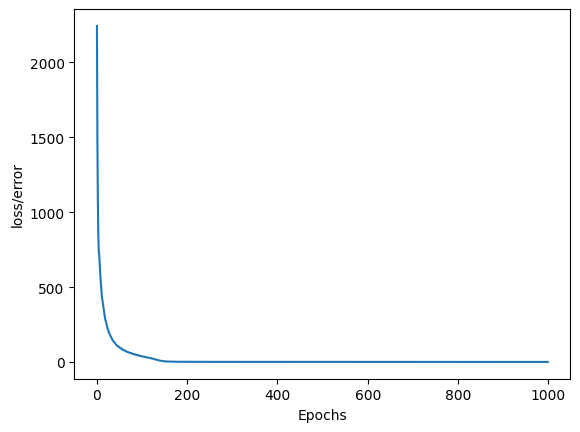

In [28]:
plt.plot(range(epochs) , losses)
plt.ylabel("loss/error")
plt.xlabel("Epochs")
plt.show()

In [29]:
correct = 0
with torch.no_grad():
    y_pred = model.forward(X_test)  # X_test is already (n_samples, n_features)
    correct = (y_pred.argmax(dim=1) == y_test).sum().item()
print(f"We have correct {correct} predictions out of {X_test.shape[0]} , percentage: {correct / X_test.shape[0] * 100:.2f}%")


We have correct 108989 predictions out of 234646 , percentage: 46.45%
